In [ ]:
%load_ext tensorboard

Load modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras import layers
import datetime

from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

Constant

In [2]:
log_dir = "../logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
batch_size=32

path="../data/"
os.listdir(path)

['Fixated.csv', 'heart+disease', 'metadata.txt']

## Pre Modelling

Read dataset

In [3]:
df=pd.read_csv(path+"fixated.csv")
labeltarget=["Tidak", "Ya"]

Train Test split

In [4]:
#train test split
X=df.copy()
y=X.pop("target")
train_data, test_data, train_value, test_value = train_test_split(X, y, train_size= 0.8)

Necessities for the model

In [5]:
#callbacks
def tensorboardlogger():
    return [keras.callbacks.ModelCheckpoint(log_dir+"/callbacks", save_weights_only=True),
            tf.keras.callbacks.TensorBoard(log_dir)]


class SelectiveProgbarLogger(tf.keras.callbacks.ProgbarLogger):
    def __init__(self, verbose, epoch_interval, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.default_verbose = verbose
        self.epoch_interval = epoch_interval
    
    def on_epoch_begin(self, epoch, *args, **kwargs):
        self.verbose = (
            0 
                if epoch % self.epoch_interval != 0 
                else self.default_verbose
        )
        super().on_epoch_begin(epoch, *args, **kwargs)

#metrics history visualization
def theplot(history):
    fig = plt.figure(figsize=(10,10))
    ax=fig.add_subplot(2,1,1)
    ax.plot(history.history["binary_accuracy"], label="binary_accuracy", c="blue")
    ax.plot(history.history["val_binary_accuracy"], label="val_binary_accuracy", c="orange")
    ax.set_xlabel("epochs")
    ax.set_ylabel("accuracy")
    ax.legend(loc="lower right")
    ax=fig.add_subplot(2,1,2)
    ax.plot(history.history["loss"], label="loss", c="blue")
    ax.plot(history.history["val_loss"], label="val_loss", c="orange")
    ax.legend(loc="lower right")
    ax.set_ylim(0,1)
    ax.set_xlabel("epochs")
    ax.set_ylabel("losses")
    
#change to binary [0,1]
def predict(model, features):
    predicted=model.predict(features)
    predicted = tf.where(predicted < 0.5, 0, 1)
    return np.array(predicted).flatten()


## Modelling

1st try

In [6]:
def build_and_compile_model():
  model = keras.Sequential([
      layers.Dense(64, activation='relu', input_dim=X.shape[1]),
      layers.Dense(128, activation='relu'),
      layers.Dense(1, activation="sigmoid")
  ])

  model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), metrics=[keras.metrics.binary_accuracy])
  return model

In [ ]:
epoch=500
test1=build_and_compile_model()
history=test1.fit(train_data, train_value, epochs=epoch, batch_size=batch_size,
          validation_data=(test_data, test_value),
          verbose=1, callbacks=tensorboardlogger())

Show history of metrics by epoch

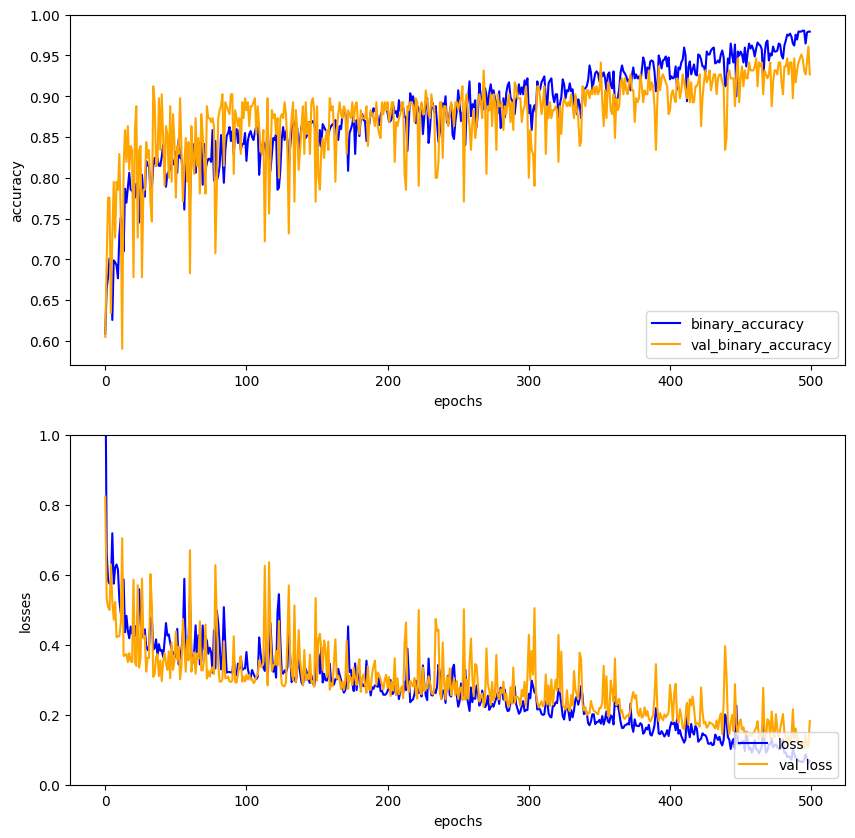

In [8]:
theplot(history)

Metrics


In [9]:
#get predicted
train_predicted=predict(test1, train_data)
test_predicted=predict(test1, test_data)

7/7 [==============================] - 0s 1ms/step


In [10]:
trainmetrics=pd.DataFrame([
    precision_score(train_value,train_predicted),
    recall_score(train_value,train_predicted),
    f1_score(train_value,train_predicted),
    accuracy_score(train_value,train_predicted)])

testmetrics=pd.DataFrame([
    precision_score(test_value,test_predicted),
    recall_score(test_value,test_predicted),
    f1_score(test_value,test_predicted),
    accuracy_score(test_value,test_predicted)])

metrics=pd.concat((trainmetrics, testmetrics), axis=1)
metrics.index=["precision_score", "recall_score", "f1_score", "accuracy_score"]
metrics.columns=["Train", "Test"]
metrics

,Train,Test
precision_score,0.994859,0.989130
recall_score,0.919240,0.866667
f1_score,0.955556,0.923858
accuracy_score,0.956098,0.926829


In [11]:
test1.save("Themodel.keras")

## Tuning

### Model and parameter declaration (DNN)

In [12]:
import keras_tuner as kt

In [13]:
#Tuning
def getmodel(hp):
  firsthidden=hp.Int('1st_layer',min_value=128,max_value=320,step=32)
  secondhidden=hp.Int('2nd_layer',min_value=128,max_value=320,step=32)
  
  hp_learning_rate = hp.Choice('learning_rate', values=[ 0.001, 1e-2, 1e-3, 1e-4])
  model = keras.Sequential()
    
  #1st layer
  model.add(keras.layers.Dense(firsthidden, activation='relu', input_dim=X.shape[1]))
  model.add(keras.layers.Dense(secondhidden, activation='relu', input_dim=X.shape[1]))
  
  #output layer
  model.add(keras.layers.Dense(1, activation="sigmoid"))

  #learning rate
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.BinaryCrossentropy(),
                metrics=["binary_accuracy"])

  return model

In [14]:
#Running the hyperparamater search with Hyperband methode
currenttime=datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

thetuner=kt.Hyperband(getmodel, objective="val_binary_accuracy",                       #Finding the best val_accuracy of the brute!
                      max_epochs=50,
                      factor=3,
                      directory="../logs/",  
                      project_name=currenttime)

Get best model

In [15]:
#Get the best model and its optimal paramaters
thetuner.search(train_data, train_value, epochs=500, validation_data=(test_data, test_value)) 


best_hps=thetuner.get_best_hyperparameters(num_trials=1)

Trial 90 Complete [00h 00m 07s]
val_binary_accuracy: 0.8975609540939331

Best val_binary_accuracy So Far: 0.9024389982223511
Total elapsed time: 00h 03m 32s
INFO:tensorflow:Oracle triggered exit


In [ ]:
#Build model with the most optimal hyperparameters and find its optimum epochs
model=thetuner.hypermodel.build(best_hps[0])

process=model.fit(train_data, train_value, epochs=1000, validation_data=(test_data, test_value))

In [49]:
print(f'Epohs   |   val_losses  |   Val_Accuracy')
yessir=sorted(list(zip(range(1, len(process.history["val_loss"])+1), process.history["val_loss"], process.history["val_binary_accuracy"])), key= lambda x:x[1])[0:5]
best_epoch=yessir[0][0]
yessir

Epohs   |   val_losses  |   Val_Accuracy


[(698, 0.0012607856187969446, 1.0),
 (706, 0.0016241720877587795, 1.0),
 (687, 0.0018805721774697304, 1.0),
 (726, 0.0018866556929424405, 1.0),
 (724, 0.0020469026640057564, 1.0)]

In [ ]:
#build model with most optimal hymperparameters and epochs
model=thetuner.hypermodel.build(best_hps[0])

bestmodel=model.fit(train_data, train_value, epochs=best_epoch, validation_data=(test_data, test_value))

Show history of metrics by epoch

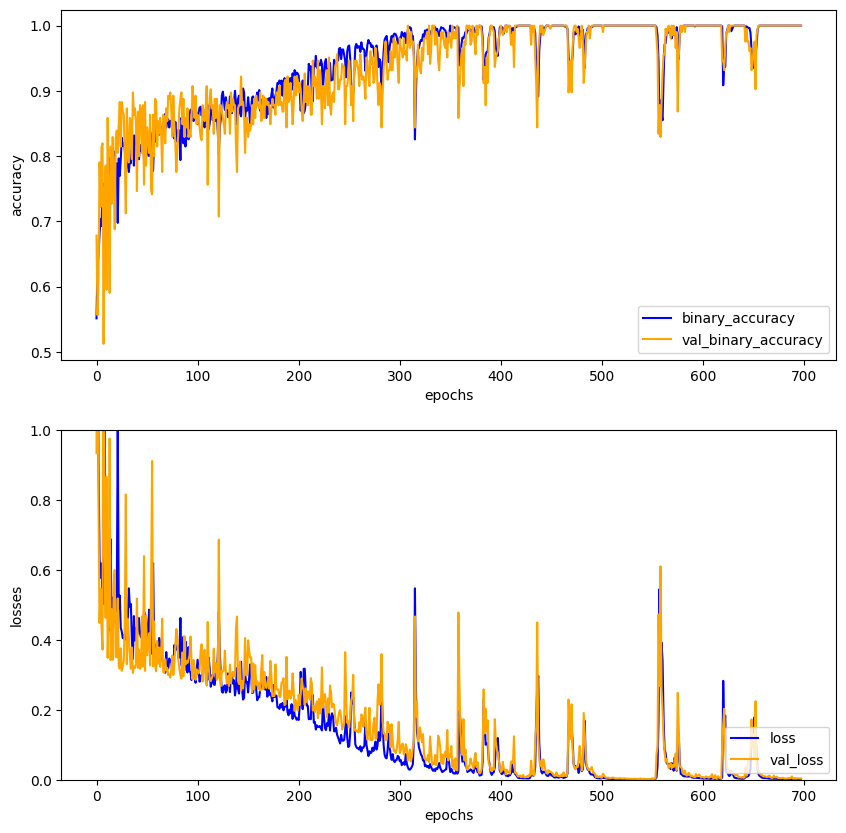

In [51]:
theplot(bestmodel)

Metrics

In [52]:
#get predicted
train_predicted=predict(model, train_data)
test_predicted=predict(model, test_data)

7/7 [==============================] - 0s 1ms/step


In [54]:
trainmetrics1=pd.DataFrame([
    precision_score(train_value,train_predicted),
    recall_score(train_value,train_predicted),
    f1_score(train_value,train_predicted),
    accuracy_score(train_value,train_predicted)])

testmetrics1=pd.DataFrame([precision_score(test_value,test_predicted),
    recall_score(test_value,test_predicted),
    f1_score(test_value,test_predicted),
    accuracy_score(test_value,test_predicted)])

metrics1=pd.concat((trainmetrics1, testmetrics1), axis=1)
metrics1.index=["precision_score", "recall_score", "f1_score", "accuracy_score"]
metrics1.columns=["Train", "Test"]
metrics1

,Train,Test
precision_score,1.0,1.0
recall_score,1.0,1.0
f1_score,1.0,1.0
accuracy_score,1.0,1.0


In [65]:
model.save("Superdupabestmodelreal.keras")

## Comparison

In [64]:
#train
comparetrain=pd.concat((metrics["Train"], metrics1["Train"]), axis=1)
comparetrain.columns=["first Model", "Best Model"]

#Test
comparetest=pd.concat((metrics["Test"], metrics1["Test"]), axis=1)
comparetest.columns=["first Model", "Best Model"]

print(f'Train:\n{comparetrain}\n\nTest:\n{comparetest}')

Train:
                 first Model  Best Model
precision_score     0.994859         1.0
recall_score        0.919240         1.0
f1_score            0.955556         1.0
accuracy_score      0.956098         1.0

Test:
                 first Model  Best Model
precision_score     0.989130         1.0
recall_score        0.866667         1.0
f1_score            0.923858         1.0
accuracy_score      0.926829         1.0
